In [1]:
#import SimpleITK as sitk
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import color, filters, morphology, util, measure, transform#, exposure, segmentation, io

from scipy.spatial import ConvexHull
from skimage.draw import line

import feret

# from scipy.signal import fftconvolve
# from scipy import ndimage
import cv2 as cv

In [1]:
from transcription_pipeline import preprocessing_pipeline

mcp_halo_test_name = "test_data/2023-08-03/embryo7"
lsm_test_name0 = "test_data/2023-03-17/p2pdp_zld-sites-all_fwd_GLC_1"
lsm_test_name1 = "test_data/2023-03-17/p2pdp_zld-sites-all_fwd_GLC_2"
lsm_test_name2 = "test_data/2023-03-17/p2pdp_zld-sites-p2pintact_fwd_GLC_1"
lsm_test_name3 = "test_data/2023-03-17/p2pdp_zld-sites-p2pintact_fwd_GLC_2"

zld_test_name0 = "test_data/2022-10-16/zld_sites_control_1"
zld_test_name1 = "test_data/2022-10-16/zld_sites_control_2"
zld_test_name2 = "test_data/2022-10-16/zld_sites_control_3"
zld_test_name3 = "test_data/2022-10-16/zld_sites_control_4"
zld_test_name4 = "test_data/2022-10-16/zld_sites_control_5"

rbs_test_name0 = "test_data/2023-05-25/RBSPWM_embryo01"
rbs_test_name1 = "test_data/2023-06-15/RBSPWM_embryo01"
rbs_test_name2 = "test_data/2023-06-16/RBSPWM_embryo01"
rbs_test_name3 = "test_data/2023-06-16/RBSPWM_embryo02"

rbs_test_name4 = "test_data/2024-07-23/Halo673_RBSVar2_embryo01"
rbs_test_name5 = "test_data/2024-07-25/Halo673_RBSVar2_embryo01"

test_dataset_name = rbs_test_name5

dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    #import_previous=True, 
)
dataset.save()

FullEmbryo = preprocessing_pipeline.FullEmbryoImport(
    name_folder=test_dataset_name,
    #import_previous=True
)
FullEmbryo.save()


`JAVA_HOME` environment variable set to /mnt/Data1/Nick/miniforge3/envs/transcription_pipeline


KeyboardInterrupt: 

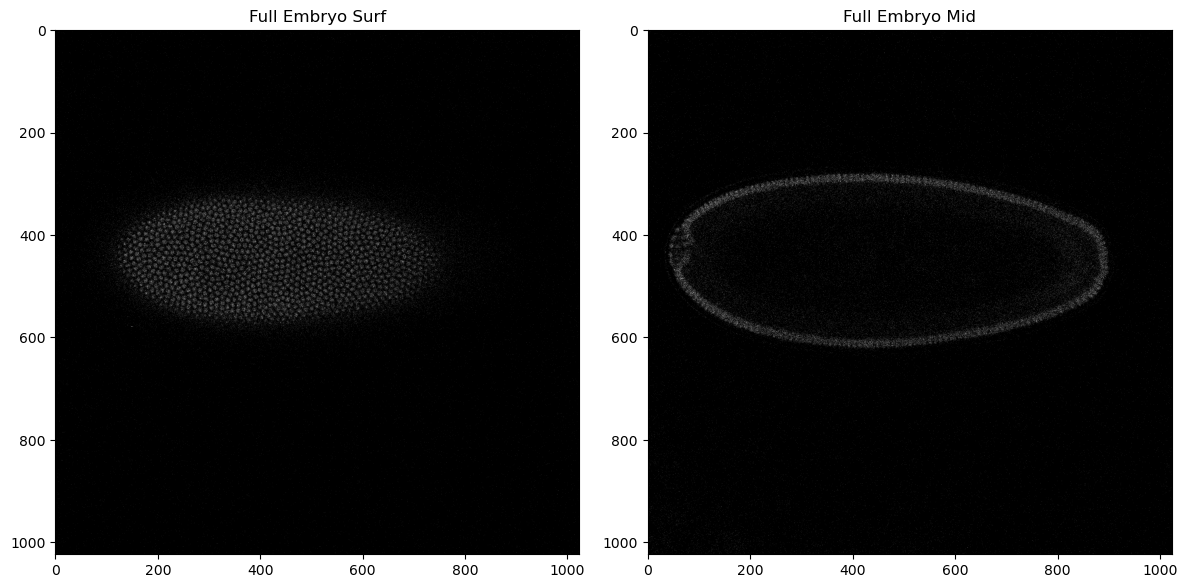

In [4]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(FullEmbryo.channels_full_dataset_surf[0][0, :, :], cmap='gray')
plt.title('Full Embryo Surf')

plt.subplot(1, 2, 2)
plt.imshow(FullEmbryo.channels_full_dataset_mid[0][0, :, :], cmap='gray')
plt.title('Full Embryo Mid')

plt.tight_layout()
plt.show()

In [13]:
##### All Functions Used to find Full Embryo AP axis #####
def contour_mask(binary_mask):
    """
    This function generates a mask by flood filling a the largest contour within the 
    input binary_mask
    """
    contours = measure.find_contours(binary_mask)
    
    # Identify the desired contour (e.g., the largest)
    largest_contour = max(contours, key=len)
    
    # Fit a convex hull to the contour
    hull = ConvexHull(largest_contour)

    # Initialize the FullEmbryo mask
    mask = np.zeros(binary_mask.shape)

    # Extract points from the contour
    pts0 = [(largest_contour[simplex, 1][0], largest_contour[simplex, 0][0]) for simplex in hull.simplices]
    pts1 = [(largest_contour[simplex, 1][1], largest_contour[simplex, 0][1]) for simplex in hull.simplices]
    pts = pts0 + pts1
    pts = np.array(pts)
    
    # Calculate reference point for determining polar angle
    # This allows us to order the points by orientation
    reference_point = np.mean(pts, axis=0)

    # Function to calculate the polar angle relative to a reference point
    def polar_angle(point):
        x, y = point[0] - reference_point[0], point[1] - reference_point[1]
        return np.arctan2(y, x)

    # Sort points based on polar angle 
    sorted_pts = sorted(pts, key=polar_angle)
    
    # Draw contour connecting sorted points
    for i in range(len(sorted_pts)):
        if i == len(sorted_pts)-1:
            x1, y1 = np.round(sorted_pts[i])
            x2, y2 = np.round(sorted_pts[0])
        else:
            x1, y1 = np.round(sorted_pts[i])
            x2, y2 = np.round(sorted_pts[i+1])
    
        x1 = int(x1); y1 = int(y1)
        x2 = int(x2); y2 = int(y2)
        
        rr, cc = line(y1, x1, y2, x2)
    
        mask[rr,cc]= 1

    # Save contour mask 
    contour_mask = mask

    # Flood fill to generate the FullEmbryo mask
    mask = morphology.flood_fill(mask, (0,0), 1, connectivity=1)
    mask = util.invert(mask)
    
    return mask, contour_mask

def fullEmbryoMask(tif_array, sigma=10, radius=5):
    """
    Creates a FullEmbryo mask by detecting the embryo edge through a guassian blur, thresholding, and a closing operation.
    To get the full mask, contour_mask is used.
    """
    # Convert the image to grayscale if it's not already
    if tif_array.shape[-1] == 3:
        grayscale_image = color.rgb2gray(tif_array)
    else:
        grayscale_image = tif_array

    # Gaussian blur the image with given sigma
    tif_array = filters.gaussian(tif_array, sigma)

    # Otsu thresholding
    threshold_value = filters.threshold_otsu(tif_array)
    tif_array = tif_array > 1*threshold_value

    # Closing withe disk of given radius
    tif_array = morphology.closing(tif_array, morphology.disk(radius))
    
    mask, contour = contour_mask(tif_array)
    return mask, contour

def find_crossPoints(img, contour,  coord1, angle, t):
    """ This method draws the lines which run through the maxferet and minferet. """
    ymax, xmax = img.shape
    xs = np.linspace(0, xmax, 2)
    if angle == np.pi / 2:
        x1 = coord1[1]
        y1 = 0
        x2 = coord1[1]
        y2 = ymax
    elif angle == 0:
        x1 = 0
        y1 = coord1[0]
        x2 = xmax
        y2 = coord1[0]
    else:
        x1 = 0
        y1 = t
        x2 = xmax
        y2 =  np.tan(angle) * xmax + t

    x1 = int(x1); y1 = int(y1)
    x2 = int(x2); y2 = int(y2)
    
    mask_height, mask_width = img.shape

    def is_inside_mask(x, y):
        return 0 <= x < mask_width and 0 <= y < mask_height
        
    def is_intersection(x,y):
        if contour[y,x]==1:
            return True
        try:
            if contour[y-1,x]==1 or contour[y+1,x]==1:
                return True
            elif contour[y,x-1]==1 or contour[y,x+1]==1:
                return True
            else:
                return False
        except:
            return False
    
    def is_point_inside_mask(x, y):
        return is_inside_mask(x, y) and is_intersection(x,y)

    intersections = []

    # Bresenham's line algorithm
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        if is_point_inside_mask(x1, y1):
            intersections.append((x1, y1))

        if x1 == x2 and y1 == y2:
            break

        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    # Filter duplicate intersection points
    intersections = list(set(intersections))

    intersections = np.array(intersections)
    #print(intersections)

    ## Collapse points within a certain radius to the average point to reduce the number of detected intersections
    def reduce_points(points, max_distance):
        reduced_points = []
        
        while len(points) > 0:
            current_point = points[0]
            points = points[1:]
            
            close_points = [current_point]
            
            for p in points:
                distance = np.linalg.norm(current_point - p)
                if distance <= max_distance:
                    close_points.append(p)
            
            average_point = np.mean(close_points, axis=0)
            reduced_points.append(average_point)
            
            points = [p for p in points if np.linalg.norm(average_point - p) > max_distance]
        
        return np.array(reduced_points)

    unique_intersections = reduce_points(intersections,5)
    
    # reference_point = np.array([0,0])
    # def polar_angle(point):
    #     x, y = point[0] - reference_point[0], point[1] - reference_point[1]
    #     return np.arctan2(y, x)
    
    # sorted_intersections = sorted(unique_intersections, key=polar_angle)
    #print(unique_intersections)
    
    return unique_intersections #sorted_intersections[0], sorted_intersections[-1]

def findAPAxis(fullEmbryo, his_channel=0, sigma=10, radius=5):
    # Calculate the Full embryo mask using the mid z-slice from the Mid image
    mask, contour = fullEmbryoMask(fullEmbryo.channels_full_dataset_mid[his_channel][1,:,:], sigma, radius)
    res = feret.calc(mask)
    #feret.plot(mask)
    theta = res.minf90_angle
    # x1, y1 = res.minf90_coords[0]
    # x2, y2 = res.minf90_coords[1]
    #print(res.minf90_t)
    AP_pts = find_crossPoints(mask, contour, res.minf90_coords[0], res.minf90_angle, res.minf90_t)
    AP90_pts = find_crossPoints(mask, contour, res.minf_coords[0], res.minf_angle, res.minf_t)

    (y1, x1) = AP_pts[0]
    (y2, x2) = AP_pts[1]

    (y3, x3) = AP90_pts[0]
    (y4, x4) = AP90_pts[1]

    x1 = int(x1); y1 = int(y1)
    x2 = int(x2); y2 = int(y2)
    x3 = int(x3); y3 = int(y3)
    x4 = int(x4); y4 = int(y4)

    rr, cc = line(y1, x1, y2, x2)
    rr2, cc2 = line(y3, x3, y4, x4)

    # Label connected components in the binary mask
    mask = (mask).astype(int)

    label_mask = measure.label(mask)

    # Calculate object properties using regionprops
    properties = measure.regionprops(mask)

    # Calculate the centroid for each labeled object
    for idx, prop in enumerate(properties):
        centroid = prop.centroid

    #print(centroid)
    # x0 = int(x0); y0 = int(y0)
    x0, y0 = centroid
    d1 = np.sqrt((x1-x0)**2 + (y1-y0)**2)
    d2 = np.sqrt((x2-x0)**2 + (y2-y0)**2)
    APd = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    AP90d = np.sqrt((x3-x4)**2 + (y3-y4)**2)

    maxD = max([d1,d2])
    minD = min([d1,d2])
    r = maxD/minD

    # print('Distance 1 = ', d1)
    # print('Distance 2 = ', d2)
    # print('Distance ratio = ', r)

    if d1 > d2:
        d1_color = 'green'; d1_label = 'Anterior'
        d2_color = 'red'; d2_label = 'Posterior'
        Anterior_point = (y1,x1)
        Posterior_point = (y2, x2)
    else:
        d1_color = 'red'; d1_label = 'Posterior'
        d2_color = 'green'; d2_label = 'Anterior'
        Anterior_point = (y2,x2)
        Posterior_point = (y1, x1)

    ## Pull last frame of histone channel from movie and histone channel of surf and mid images
    ImgWindow = dataset.channels_full_dataset[his_channel][-1,:,:,:]
    Surf = FullEmbryo.channels_full_dataset_surf[his_channel][:,:,:]
    Mid = FullEmbryo.channels_full_dataset_mid[his_channel][:,:,:]

    ## Max projection of ImgWindow and Surf
    ImgWindow_max = np.max(ImgWindow, axis=0)
    Surf_max = np.max(Surf, axis=0)

    ### Imaging parameters for Surf
    Surf_numX = FullEmbryo.export_global_metadata_surf[1]['PixelsSizeX']
    Surf_dX = FullEmbryo.export_global_metadata_surf[1]['PixelsPhysicalSizeX']

    Surf_numY = FullEmbryo.export_global_metadata_surf[1]['PixelsSizeY']
    Surf_dY = FullEmbryo.export_global_metadata_surf[1]['PixelsPhysicalSizeY']

    Surf_numZ = FullEmbryo.export_global_metadata_surf[1]['PixelsSizeZ']
    Surf_dZ = FullEmbryo.export_global_metadata_surf[1]['PixelsPhysicalSizeZ']

    Surf_spacing = (Surf_dZ, Surf_dY, Surf_dX)

    ### Imaging parameters for ImgWindow

    ImgWindow_numX = dataset.export_global_metadata[1]['PixelsSizeX']
    ImgWindow_dX = dataset.export_global_metadata[1]['PixelsPhysicalSizeX']

    ImgWindow_numY = dataset.export_global_metadata[1]['PixelsSizeY']
    ImgWindow_dY = dataset.export_global_metadata[1]['PixelsPhysicalSizeY']

    ImgWindow_numZ = dataset.export_global_metadata[1]['PixelsSizeZ']
    ImgWindow_dZ = dataset.export_global_metadata[1]['PixelsPhysicalSizeZ']

    ImgWindow_spacing = (ImgWindow_dZ, ImgWindow_dY, ImgWindow_dX)

    ## Rescale ImgWindow_max to match the zoom of Surf
    ImgWindow_max_rescaled = transform.rescale(ImgWindow_max, ((ImgWindow_spacing[2]/Surf_spacing[2]))**(1), anti_aliasing=True)

    template = ImgWindow_max_rescaled
    img = Surf_max
    img = img.astype(np.float32)
    template = template.astype(np.float32)
    w, h = template.shape[::-1]
    # print(template.shape)
    # print(img.shape)

    # Apply template Matching
    method = eval('cv.TM_CCOEFF_NORMED')
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    bottom_left = max_loc

    plt.imshow(res, cmap='gray')
    # Overlay max position as point
    plt.scatter(max_loc[0], max_loc[1], s=20, alpha=0.8, color='red')

    fig,axes = plt.subplots(1,2, figsize=(12, 6))

    rect = patches.Rectangle((bottom_left[0], bottom_left[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axes[0].add_patch(rect)
    axes[0].imshow(img,cmap='gray')
    axes[0].set_title('Overlay with Surf Image')

    rect = patches.Rectangle((bottom_left[0], bottom_left[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axes[1].add_patch(rect)
    axes[1].imshow(Mid[0,:,:],cmap='gray')
    axes[1].imshow(mask, alpha=0.2)
    axes[1].plot(rr,cc)
    axes[1].plot(rr2,cc2)
    axes[1].scatter(y1,x1, s=20, alpha=0.8, label=d1_label, color=d1_color)
    axes[1].scatter(y2,x2, s=20, alpha=0.8, label=d2_label, color=d2_color)
    axes[1].scatter(y3,x3, s=20, alpha=0.8, label='DV', color='blue')
    axes[1].scatter(y4,x4, s=20, alpha=0.8, color='blue')
    axes[1].set_title('Overlay with Mid Image')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Added by Josh: scale factor calculation
    w_0 = ImgWindow_max.shape[1] # width of the original image
    h_0 = ImgWindow_max.shape[0] # height of the original image
    scale_factor_w = w/w_0
    scale_factor_h = h/h_0
    scale_factor = np.mean([scale_factor_w, scale_factor_h])

    return theta, Anterior_point, Posterior_point, (APd, AP90d), bottom_left, (w,h), (w_0, h_0), scale_factor

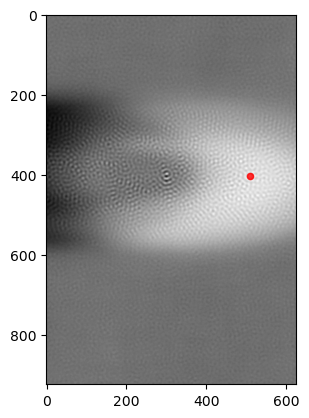

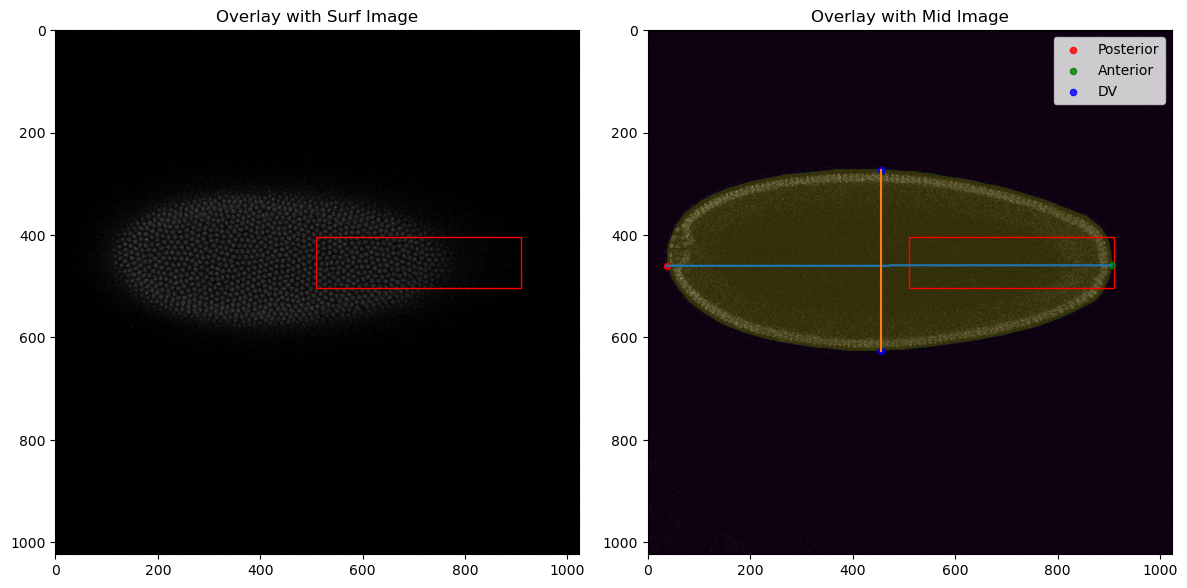

Coordinate convention: (x, y)
Anterior point = (906, 459)
Posterior point = (37, 460)
Upper left point = (509, 404)

Image dimension: (1024, 256)
Template dimension: (401, 100)
Scale factor = 0.39111328125


In [14]:
theta, Anterior_point, Posterior_point, dist, bottom_left, template_dim, Img_dim, scale_factor = findAPAxis(FullEmbryo)
print('Coordinate convention: (x, y)')
print('Anterior point =', Anterior_point)
print('Posterior point =', Posterior_point)
print('Upper left point =', bottom_left) # Note: bottom_left is actually the coordinate of the upper left point of the image window
# print(180-theta*(180/np.pi))
print('\nImage dimension:', Img_dim)
print('Template dimension:', template_dim)
print('Scale factor =', scale_factor)

AP axis length (pixels): 875.849872980524
"DV" axis length (pixels): 369.2654871498283 

The original image coordinates:  [359 473]
Transformed coordinates:  [204.76046299 -15.56125952]
Transformed coordinates (AP %):  [ 0.23378489 -0.04214112]


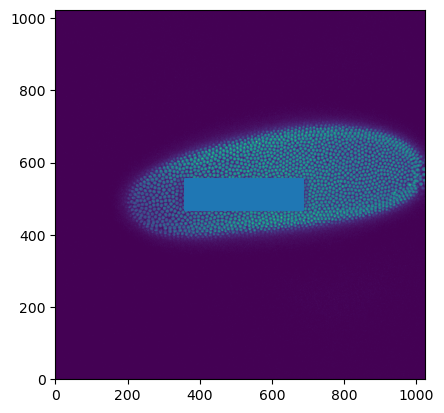

<Figure size 640x480 with 0 Axes>

In [77]:
# Output the (AP, DV) coordinate for each pixel on the rescaled image window on the full embryo image

# index of the point you want to see
i = 1

from skimage.transform import AffineTransform
# Generate the array of image coordinates in the template image
# print(template_dim[0], template_dim[1])
template_coordinates = np.indices((template_dim[0], template_dim[1])).reshape(2, -1).T

# unscaled_coords = np.indices((1024, 256)).reshape(2, -1).T
# scaled_coords = 0.32*unscaled_coords

# Shift the coordinates to the larger image coordinate system
larger_image_coordinates = template_coordinates + [bottom_left[0], bottom_left[1]]

plt.imshow(np.max(FullEmbryo.channels_full_dataset_surf[1][:,:,:], axis=0), origin='lower')
plt.scatter(larger_image_coordinates[:,0], larger_image_coordinates[:,1],s=1)

# Define the affine transformation matrix
transform_matrix1 = AffineTransform(translation=(-Anterior_point[0], -Anterior_point[1]))
transform_matrix2 = AffineTransform(rotation=-(theta%(np.pi)))

# Apply the affine transformation to the larger image coordinates
transformed_coordinates = transform_matrix2(transform_matrix1(larger_image_coordinates))

# Calculate the transformed coordinates in terms of (AP, DV) percentages
transformed_coords_AP = transformed_coordinates/dist

# Plot the transformed coordinates
#plt.imshow(np.max(FullEmbryo.channels_full_dataset_surf[1][:,:,:], axis=0), origin='upper')
plt.figure()
#plt.scatter(larger_image_coordinates[:, 0], larger_image_coordinates[:, 1], s=1)
print('AP axis length (pixels):', dist[0])
print('"DV" axis length (pixels):', dist[1], '\n')
print("The original image coordinates: ", larger_image_coordinates[i])
print("Transformed coordinates: ", transformed_coordinates[i])
print("Transformed coordinates (AP %): ", transformed_coords_AP[i])
# plt.xlim(0,1000)
# plt.ylim(0,1000)


AP axis length (pixels): 875.849872980524
"DV" axis length (pixels): 369.2654871498283 

The larger image coordinates:  [359.         472.95800781]
Transformed coordinates:  [204.75483948 -15.60287346]
Transformed coordinates (AP %):  [ 0.23377847 -0.04225381]
[[ 0.23363199 -0.0448248 ]
 [ 0.23368081 -0.0439678 ]
 [ 0.23372964 -0.04311081]
 ...
 [ 0.61561247  0.05352142]
 [ 0.6156613   0.05437842]
 [ 0.61571012  0.05523542]]


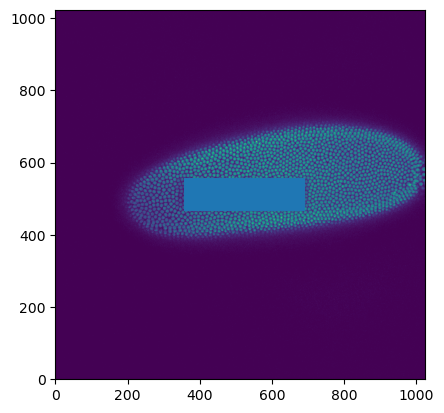

<Figure size 640x480 with 0 Axes>

In [83]:
# Added by Josh: output the (AP, DV) coordinate for each pixel on the original image window

# index of the point you want to see
i = 3

from skimage.transform import AffineTransform
# Generate the array of image coordinates in the template image
unscaled_coords = np.indices((Img_dim[0], Img_dim[1])).reshape(2, -1).T
scaled_coords = scale_factor*unscaled_coords

# Shift the coordinates to the larger image coordinate system
larger_image_coordinates = scaled_coords + [bottom_left[0], bottom_left[1]]

plt.imshow(np.max(FullEmbryo.channels_full_dataset_surf[1][:,:,:], axis=0), origin='lower')
plt.scatter(larger_image_coordinates[:,0], larger_image_coordinates[:,1],s=1)

# Define the affine transformation matrix
transform_matrix1 = AffineTransform(translation=(-Anterior_point[0], -Anterior_point[1]))
transform_matrix2 = AffineTransform(rotation=-(theta%(np.pi)))

# Apply the affine transformation to the larger image coordinates
transformed_coordinates = transform_matrix2(transform_matrix1(larger_image_coordinates))

# Calculate the transformed coordinates in terms of (AP, DV) percentages
transformed_coords_AP = transformed_coordinates/dist

# Plot the transformed coordinates
#plt.imshow(np.max(FullEmbryo.channels_full_dataset_surf[1][:,:,:], axis=0), origin='upper')
plt.figure()
#plt.scatter(larger_image_coordinates[:, 0], larger_image_coordinates[:, 1], s=1)
print('AP axis length (pixels):', dist[0])
print('"DV" axis length (pixels):', dist[1], '\n')
print("The larger image coordinates: ", larger_image_coordinates[i])
print("Transformed coordinates: ", transformed_coordinates[i])
print("Transformed coordinates (AP %): ", transformed_coords_AP[i])
# plt.xlim(0,1000)
# plt.ylim(0,1000)
print(transformed_coords_AP)

## A function that outputs the (AP, DV) coordinate for the points fed in

In [106]:
# Added by Josh: A function that outputs the (AP, DV) coordinate for the point fed in
def XY_to_AP(points_in_ImgWindow, fullEmbryo):
    # points_in_ImgWindow: a numpy array of dimension (N,2), e.g. np.array([[1,1]]) or np.array([[1,2], [3,4]]) *Notice the double brackets!*
    # fullEmbryo: the embryo file variable name

    # Retrieve the information of the image of an embryo
    theta, Anterior_point, Posterior_point, dist, bottom_left, template_dim, Img_dim, scale_factor = findAPAxis(fullEmbryo)
    

    from skimage.transform import AffineTransform
    # Generate the coordinates of the points_in_ImgWindow in the imaging window in the full embryo image
    scaled_coords = scale_factor*points_in_ImgWindow

    # Shift the coordinates to the larger image coordinate system
    larger_image_coordinates = scaled_coords + [bottom_left[0], bottom_left[1]]

    # Define the affine transformation matrix
    transform_matrix1 = AffineTransform(translation=(-Anterior_point[0], -Anterior_point[1]))
    transform_matrix2 = AffineTransform(rotation=-(theta%(np.pi)))

    # Apply the affine transformation to the larger image coordinates
    transformed_coordinates = transform_matrix2(transform_matrix1(larger_image_coordinates))

    # Calculate the transformed coordinates in terms of (AP, DV) percentages
    transformed_coords_AP = transformed_coordinates/dist

    return transformed_coords_AP

Check whether `XY_to_APDV` is correct

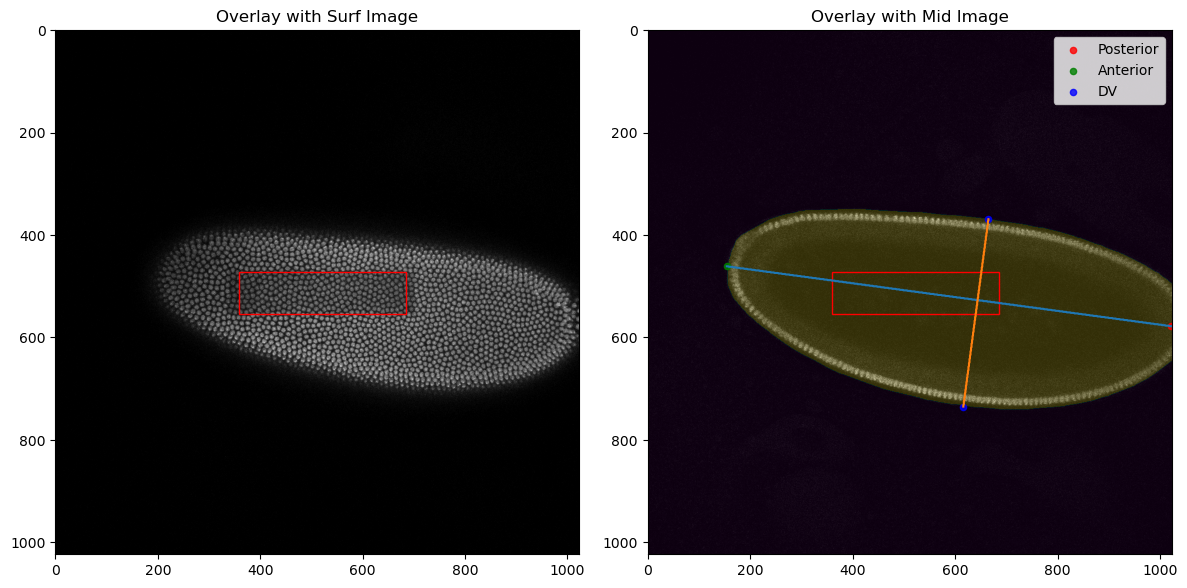

array([[ 0.23363199, -0.0448248 ],
       [ 0.23368081, -0.0439678 ],
       [ 0.23372964, -0.04311081],
       ...,
       [ 0.61561247,  0.05352142],
       [ 0.6156613 ,  0.05437842],
       [ 0.61571012,  0.05523542]])

In [107]:
XY_to_AP(unscaled_coords, FullEmbryo)

In [101]:
print(unscaled_coords[2], unscaled_coords[4], unscaled_coords[6])

[0 2] [0 4] [0 6]


In [100]:
print(transformed_coords_AP[2], transformed_coords_AP[4], transformed_coords_AP[6])

[ 0.23372964 -0.04311081] [ 0.23382729 -0.04139681] [ 0.23392495 -0.03968282]


Conclusion: <font color=green>correct</font>

In [8]:
# Calculate the Full embryo mask using the mid z-slice from the Mid image
mask, contour = fullEmbryoMask(FullEmbryo.channels_full_dataset_mid[1][1,:,:])
#plot_contours(binary_mask)
# plt.show()
# plt.figure()
# plt.imshow(tif_array)
# plt.imshow(mask, alpha=0.5)
# plt.figure()
# plt.imshow(contour)

Distance 1 =  423.9313784380911
Distance 2 =  452.6832857363818
Distance ratio =  1.0678220786680679


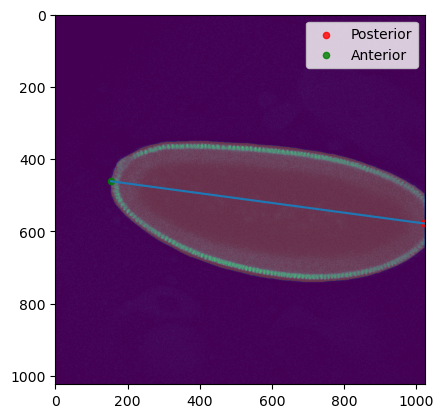

In [9]:
res = feret.calc(mask)
# x1, y1 = res.minf90_coords[0]
# x2, y2 = res.minf90_coords[1]
#print(res.minf90_t)
pts = find_crossPoints(mask, contour, res.minf90_coords[0], res.minf90_angle, res.minf90_t)
(y1, x1) = pts[0]
(y2, x2) = pts[1]

x1 = int(x1); y1 = int(y1)
x2 = int(x2); y2 = int(y2)

rr, cc = line(y1, x1, y2, x2)

# Label connected components in the binary mask
mask = (mask).astype(int)

label_mask = measure.label(mask)

# Calculate object properties using regionprops
properties = measure.regionprops(mask)

# Calculate the centroid for each labeled object
for idx, prop in enumerate(properties):
    centroid = prop.centroid

#print(centroid)
# x0 = int(x0); y0 = int(y0)
x0, y0 = centroid
d1 = np.sqrt((x1-x0)**2 + (y1-y0)**2)
d2 = np.sqrt((x2-x0)**2 + (y2-y0)**2)

maxD = max([d1,d2])
minD = min([d1,d2])
r = maxD/minD

print('Distance 1 = ', d1)
print('Distance 2 = ', d2)
print('Distance ratio = ', r)

if d1 > d2:
    d1_color = 'green'; d1_label = 'Anterior'
    d2_color = 'red'; d2_label = 'Posterior'
else:
    d1_color = 'red'; d1_label = 'Posterior'
    d2_color = 'green'; d2_label = 'Anterior'

#plt.scatter(y0,x0, s=20, alpha=0.8)
plt.imshow(FullEmbryo.channels_full_dataset_mid[1][0, :, :])
plt.imshow(mask, alpha=0.2)
plt.plot(rr,cc)
plt.scatter(y1,x1, s=20, alpha=0.8, label=d1_label, color=d1_color)
plt.scatter(y2,x2, s=20, alpha=0.8, label=d2_label, color=d2_color)
plt.legend()
#print(res.minf90_coords)


In [10]:
## Pull last frame of histone channel from movie and histone channel of surf image
ImgWindow = dataset.channels_full_dataset[1][-1,:,:,:]
Surf = FullEmbryo.channels_full_dataset_surf[1][:,:,:]
Mid = FullEmbryo.channels_full_dataset_mid[1][:,:,:]

## Max projection of ImgWindow and Surf
ImgWindow_max = np.max(ImgWindow, axis=0)
Surf_max = np.max(Surf, axis=0)

### Imaging parameters for Surf
Surf_numX = FullEmbryo.export_global_metadata_surf[1]['PixelsSizeX']
Surf_dX = FullEmbryo.export_global_metadata_surf[1]['PixelsPhysicalSizeX']

Surf_numY = FullEmbryo.export_global_metadata_surf[1]['PixelsSizeY']
Surf_dY = FullEmbryo.export_global_metadata_surf[1]['PixelsPhysicalSizeY']

Surf_numZ = FullEmbryo.export_global_metadata_surf[1]['PixelsSizeZ']
Surf_dZ = FullEmbryo.export_global_metadata_surf[1]['PixelsPhysicalSizeZ']

Surf_spacing = (Surf_dZ, Surf_dY, Surf_dX)

### Imaging parameters for ImgWindow

ImgWindow_numX = dataset.export_global_metadata[1]['PixelsSizeX']
ImgWindow_dX = dataset.export_global_metadata[1]['PixelsPhysicalSizeX']

ImgWindow_numY = dataset.export_global_metadata[1]['PixelsSizeY']
ImgWindow_dY = dataset.export_global_metadata[1]['PixelsPhysicalSizeY']

ImgWindow_numZ = dataset.export_global_metadata[1]['PixelsSizeZ']
ImgWindow_dZ = dataset.export_global_metadata[1]['PixelsPhysicalSizeZ']

ImgWindow_spacing = (ImgWindow_dZ, ImgWindow_dY, ImgWindow_dX)

## Rescale ImgWindow_max to match the zoom of Surf
ImgWindow_max_rescaled = transform.rescale(ImgWindow_max, ((ImgWindow_spacing[2]/Surf_spacing[2]))**(1), anti_aliasing=True)

(82, 326)
(1024, 1024)


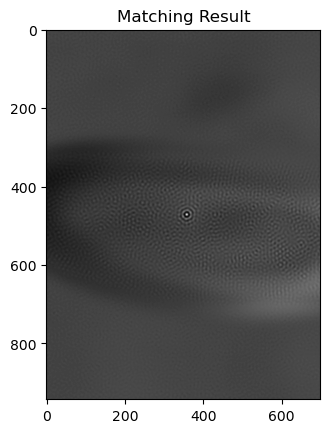

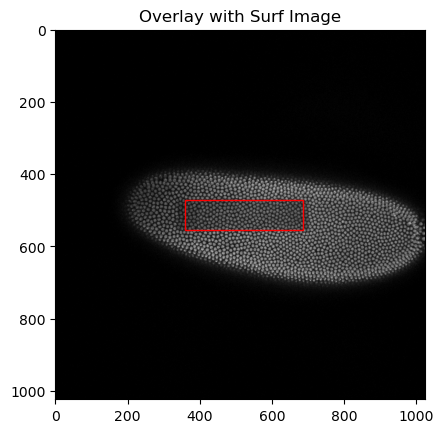

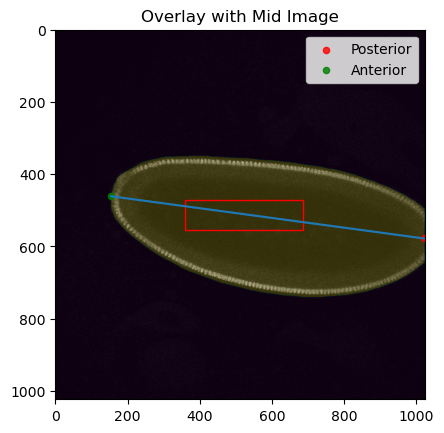

In [11]:
template = ImgWindow_max_rescaled 
img = Surf_max
img = img.astype(np.float32)
template = template.astype(np.float32)
w, h = template.shape[::-1]
print(template.shape)
print(img.shape)

# Apply template Matching
method = eval('cv.TM_CCOEFF_NORMED')
res = cv.matchTemplate(img,template,method)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
bottom_left = max_loc


plt.figure()
plt.imshow(res,cmap = 'gray')
plt.title('Matching Result')

fig,ax = plt.subplots()
rect = patches.Rectangle((bottom_left[0], bottom_left[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.imshow(img,cmap='gray')
plt.title('Overlay with Surf Image')
plt.show()

fig,ax = plt.subplots()
rect = patches.Rectangle((bottom_left[0], bottom_left[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.imshow(Mid[0,:,:],cmap='gray')
plt.imshow(mask, alpha=0.2)
plt.plot(rr,cc)
plt.scatter(y1,x1, s=20, alpha=0.8, label=d1_label, color=d1_color)
plt.scatter(y2,x2, s=20, alpha=0.8, label=d2_label, color=d2_color)
plt.legend()
plt.title('Overlay with Mid Image')
plt.show()

## Testing `AffineTransform`

In [104]:
from skimage.transform import AffineTransform
import numpy as np

# Define the rotation angle in radians
rotation_angle = -np.pi/6
# Define the translation parameters
# translation_x = -Anterior_point[0]
# translation_y = -Anterior_point[1]
translation_x = -50
translation_y = -50


#R = AffineTransform(rotation=rotation_angle)
affine_transform = AffineTransform(translation=(translation_x, translation_y), rotation=rotation_angle)

template_coords = np.array([[0,0],[0,50],[50,0],[50,50]])
transformed_template_coords = affine_transform(template_coords)
print(transformed_template_coords)

# Original coordinates
x_original = template_coords[:, 0]
y_original = template_coords[:, 1]

# Rotated coordinates
x_rotated = transformed_template_coords[:, 0]
y_rotated = transformed_template_coords[:, 1]

# Plotting
plt.figure(figsize=(8, 8))
ax.set_aspect('equal')
plt.scatter(x_original, y_original, color='blue', label='Original')
plt.scatter(x_rotated, y_rotated, color='red', label='Rotated')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original and Rotated Coordinates')
plt.legend()
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.show()

[[-50.         -50.        ]
 [-25.          -6.69872981]
 [ -6.69872981 -75.        ]
 [ 18.30127019 -31.69872981]]


NameError: name 'ax' is not defined

<Figure size 800x800 with 0 Axes>

[[ 18.30127019 -31.69872981]
 [ 43.30127019  11.60254038]
 [ 61.60254038 -56.69872981]
 [ 86.60254038 -13.39745962]]


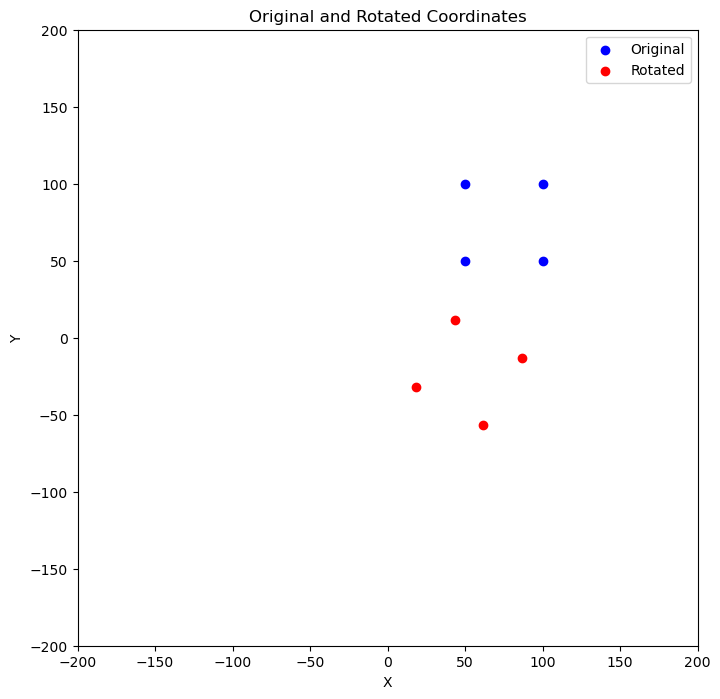

In [58]:
from skimage.transform import AffineTransform
import numpy as np

# Define the rotation angle in radians
rotation_angle = -np.pi/6
# Define the translation parameters
# translation_x = -Anterior_point[0]
# translation_y = -Anterior_point[1]
translation_x = -50
translation_y = -50


#R = AffineTransform(rotation=rotation_angle)
affine_transform = AffineTransform(translation=(translation_x, translation_y), rotation=rotation_angle)

template_coords = np.array([[50,50],[50,100],[100,50],[100,100]])
transformed_template_coords = affine_transform(template_coords)
print(transformed_template_coords)

# Original coordinates
x_original = template_coords[:, 0]
y_original = template_coords[:, 1]

# Rotated coordinates
x_rotated = transformed_template_coords[:, 0]
y_rotated = transformed_template_coords[:, 1]

# Plotting
plt.figure(figsize=(8, 8))
ax.set_aspect('equal')
plt.scatter(x_original, y_original, color='blue', label='Original')
plt.scatter(x_rotated, y_rotated, color='red', label='Rotated')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original and Rotated Coordinates')
plt.legend()
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.show()

[[  0.           0.        ]
 [ 25.          43.30127019]
 [ 43.30127019 -25.        ]
 [ 68.30127019  18.30127019]]


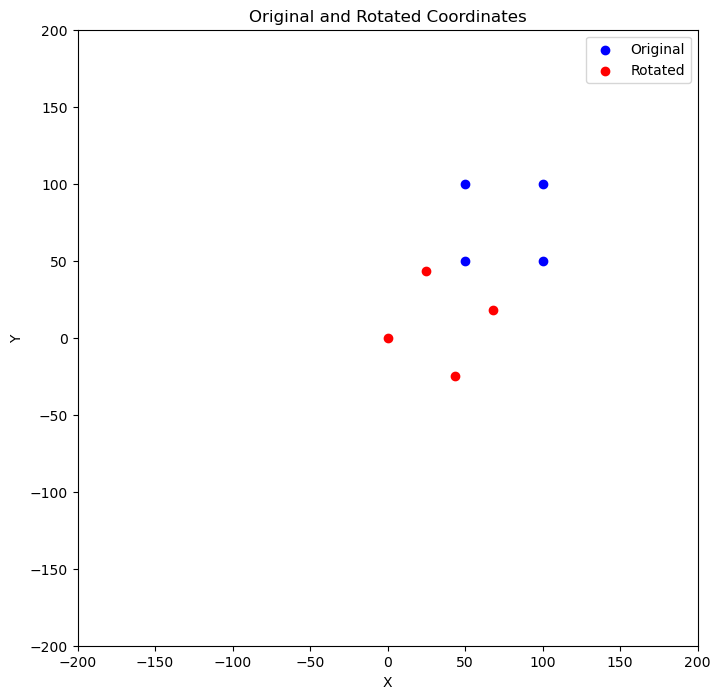

In [55]:
from skimage.transform import AffineTransform
import numpy as np

# Define the rotation angle in radians
rotation_angle = -np.pi/6
# Define the translation parameters
# translation_x = -Anterior_point[0]
# translation_y = -Anterior_point[1]
translation_x = -50
translation_y = -50


#R = AffineTransform(rotation=rotation_angle)
affine_transform1 = AffineTransform(translation=(translation_x, translation_y))
affine_transform2 = AffineTransform(rotation=rotation_angle)

template_coords = np.array([[50,50],[50,100],[100,50],[100,100]])
transformed_template_coords = affine_transform2(affine_transform1(template_coords))
print(transformed_template_coords)

# Original coordinates
x_original = template_coords[:, 0]
y_original = template_coords[:, 1]

# Rotated coordinates
x_rotated = transformed_template_coords[:, 0]
y_rotated = transformed_template_coords[:, 1]

# Plotting
plt.figure(figsize=(8, 8))
ax.set_aspect('equal')
plt.scatter(x_original, y_original, color='blue', label='Original')
plt.scatter(x_rotated, y_rotated, color='red', label='Rotated')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original and Rotated Coordinates')
plt.legend()
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.show()